## <center> Feature importance

#### **1/ Import all necessary libraries and classes to run this notebook**

In [ ]:
pip install git+https://github.com/edikedik/eBoruta.git

  Cloning https://github.com/edikedik/eBoruta.git to /tmp/pip-req-build-xos_5cp2
  Running command git clone --filter=blob:none --quiet https://github.com/edikedik/eBoruta.git /tmp/pip-req-build-xos_5cp2
  Resolved https://github.com/edikedik/eBoruta.git to commit 8df25a12d1147770002085563283c03f24213e41
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.0 MB/s eta 0:00:00
  Created wheel for eBoruta: filename=eboruta-0.1-py3-none-any.whl size=20206 sha256=2f0c1be0fcd4619d4f6aa5166dd27958065f878e2f090dcfa99daa878668e38a
  Stored in directory: /tmp/pip-ephem-wheel-cache-r4u6udr6/wheels/5c/a3/fd/9b1654a204a56073be3fa739a680d53c5de421cd015199d684
Successfully built eBoruta


In [ ]:
from typing import Callable
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import RandomForestClassifier

from eBoruta import eBoruta, TrialData, Features, Dataset, setup_logger
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

#### **2/ Read and preprocess the data**

In [ ]:
df = pd.read_csv('x_ray_and_features_data.csv')
df.columns

Index(['subject_id', 'diabete', 'age', 'hiv', 'oxygen', 'heart_rate',
       'temperature', 'hemoglobin', 'rbc', 'wbc', 'sputum_culture', 'smoke',
       'cough', 'pneumonia', 'tuberculosis', 'bronchitis', 'arthritis',
       'fracture', 'lung_cancer', 'scoliosis', 'lung_infection', 'Unnamed: 0',
       'file_name', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', 'dicom', 'StudyDate',
       'hadm_id', 'admittime', 'dischtime', 'time'],
      dtype='object')

In [ ]:
mimic_feats = ['diabete', 'age', 'hiv', 'oxygen', 'heart_rate', 'temperature', 'hemoglobin', 'rbc', 'wbc', 'sputum_culture', 'smoke', 'cough']
img_feats = [str(x) for x in range(18)]

In [ ]:
df[['pneumonia', 'tuberculosis', 'bronchitis', 'arthritis', 'fracture', 'lung_cancer', 'scoliosis', 'lung_infection']].apply(pd.Series.value_counts)

,pneumonia,tuberculosis,bronchitis,arthritis,fracture,lung_cancer,scoliosis,lung_infection
0,21069,28282,27564,27861,26978,21277,28902,28103
1,7983,770,1488,1191,2074,7775,150,949


In [ ]:
bron = df['bronchitis']
pneu = df['pneumonia']
tub = df['tuberculosis']
art = df['arthritis']
frac = df['fracture']
can = df['lung_cancer']
sco = df['scoliosis']
inf = df['lung_infection']
d1 = df[img_feats]
d2 = df[img_feats+mimic_feats]


#### **3/ XGB gain importance**

The GXB importance algorithm is a feature selection method used in machine learning. It assesses the importance of features by considering the gain achieved by a feature when used for splitting in decision trees, weighted by the frequency of that feature being chosen as the splitting attribute, helping to identify influential variables in predictive modeling.

### Feature importance per disease

In [ ]:
for l in [bron, pneu, tub, art, frac, can, sco, inf]:
  print(f"\n\nResult for: {l.name}\n\n")
  model = XGBClassifier()
  model.fit(d2, l)

  importance_type = 'gain'  # Use 'weight' or 'gain' as desired
  importance_scores = model.feature_importances_

  feature_importance_df = pd.DataFrame({'Feature': d2.columns, 'Importance': importance_scores})
  feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

  print(feature_importance_df.to_string(index=False))



Result for: bronchitis


       Feature  Importance
           rbc    0.061143
         smoke    0.060987
           hiv    0.055220
           age    0.054182
sputum_culture    0.049951
       diabete    0.049506
    hemoglobin    0.045171
           wbc    0.042169
        oxygen    0.038296
   temperature    0.034817
    heart_rate    0.034734
             7    0.031210
            11    0.028941
            14    0.028696
             0    0.028513
             4    0.027510
            12    0.027132
             1    0.026027
            17    0.026009
             9    0.025583
             2    0.025263
            16    0.024899
             5    0.024423
             8    0.024250
             3    0.023995
            10    0.023762
            13    0.023018
             6    0.022883
            15    0.022584
         cough    0.009129


Result for: pneumonia


       Feature  Importance
sputum_culture    0.153342
        oxygen    0.111021
       diabete    0.085741
  

### Feature importance for all the data

In [ ]:
target_variables = [bron, pneu, tub, art, frac, can, sco, inf]

df_feature_importance = pd.DataFrame()  # DataFrame to store the mean feature importance

for y in target_variables:
    model = XGBClassifier()
    model.fit(d2, y)

    importance_type = 'gain'  # Use 'weight' or 'gain' as desired
    importance_scores = model.feature_importances_

    feature_importance_df = pd.DataFrame({'Feature': d2.columns, 'Importance': importance_scores})
    df_feature_importance[y.name] = feature_importance_df['Importance']

df_feature_importance['Mean_Importance'] = df_feature_importance.mean(axis=1)

df_feature_importance['Feature'] = feature_importance_df['Feature']

df_feature_importance = df_feature_importance.sort_values(by='Mean_Importance', ascending=False)

print("Feature Importance for All Targets:")
print(df_feature_importance[['Feature', 'Mean_Importance']].to_string(index=False))

Feature Importance for All Targets:
       Feature  Mean_Importance
       diabete         0.058872
           age         0.054668
           rbc         0.053932
sputum_culture         0.050810
         smoke         0.050214
           hiv         0.049596
    hemoglobin         0.048726
           wbc         0.048638
    heart_rate         0.048338
        oxygen         0.046581
   temperature         0.044884
            14         0.026875
            16         0.025687
            17         0.025361
             3         0.024995
             7         0.024877
            10         0.024682
             8         0.024469
             6         0.023682
             4         0.023516
            12         0.023298
             5         0.023258
            13         0.023183
            11         0.023064
             1         0.022992
            15         0.022980
             0         0.022902
             9         0.022852
             2         0.022126
    

#### **3/ eBoruta feature importance**

The eBoruta algorithm is an extension of the Boruta feature selection method used for machine learning, that integrates the SHAP (SHapley Additive exPlanations) importance measure. It employs a recursive approach with randomization to determine the significance of features and is primarily designed for identifying relevant features in high-dimensional datasets, such as those in bioinformatics and genomics.

In [ ]:
# Need a data without any missing value
df.fillna(df.mean(), inplace=True)

# The SHAP importance measure makes the algorithm very long to run (espacially on large data set)
# Thus we will shuffle it and reduce it
df = df.sample(frac=1).head(1000)

bron = df['bronchitis']
pneu = df['pneumonia']
tub = df['tuberculosis']
art = df['arthritis']
frac = df['fracture']
can = df['lung_cancer']
sco = df['scoliosis']
inf = df['lung_infection']
d1 = df[img_feats]
d2 = df[img_feats+mimic_feats]

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [ ]:
df[['pneumonia', 'tuberculosis', 'bronchitis', 'arthritis', 'fracture', 'lung_cancer', 'scoliosis', 'lung_infection']].apply(pd.Series.value_counts)

,pneumonia,tuberculosis,bronchitis,arthritis,fracture,lung_cancer,scoliosis,lung_infection
0,703,969,944,956,928,739,997,961
1,297,31,56,44,72,261,3,39


In [ ]:
def plot_imp_history(df_history: pd.DataFrame):
    sns.lineplot(x='Step', y='Importance', hue='Feature', data=df_history)
    sns.lineplot(x='Step', y='Threshold', data=df_history, linestyle='--', linewidth=4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

Boruta trials:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:eBoruta.algorithm:Trial 1: sampled trial data with shapes x_train: (1000, 60), y_train: (1000,), x_test: (1000, 60), y_test: (1000,)
INFO:eBoruta.algorithm:63.33% (19) recorded as hits
INFO:eBoruta.algorithm:Out of 30: {'accepted': 0, 'rejected': 0, 'tentative': 30}
INFO:eBoruta.algorithm:Total summary: {'accepted': 0, 'rejected': 0, 'tentative': 30}
INFO:eBoruta.algorithm:Trial 2: sampled trial data with shapes x_train: (1000, 60), y_train: (1000,), x_test: (1000, 60), y_test: (1000,)
INFO:eBoruta.algorithm:63.33% (19) recorded as hits
INFO:eBoruta.algorithm:Out of 30: {'accepted': 0, 'rejected': 0, 'tentative': 30}
INFO:eBoruta.algorithm:Total summary: {'accepted': 0, 'rejected': 0, 'tentative': 30}
INFO:eBoruta.algorithm:Trial 3: sampled trial data with shapes x_train: (1000, 60), y_train: (1000,), x_test: (1000, 60), y_test: (1000,)
INFO:eBoruta.algorithm:63.33% (19) recorded as hits
INFO:eBoruta.algorithm:Out of 30: {'accepted': 0, 'rejected': 0, 'tentative': 30}
INFO:eBoruta

['0' '1' '3' '4' '7' '8' '10' '14' '15' '16' '17' 'diabete' 'age' 'oxygen'
 'heart_rate' 'temperature' 'hemoglobin' 'rbc' 'wbc'] ['2' '5' '6' '9' '11' '12' '13' 'hiv' 'sputum_culture' 'smoke' 'cough'] []


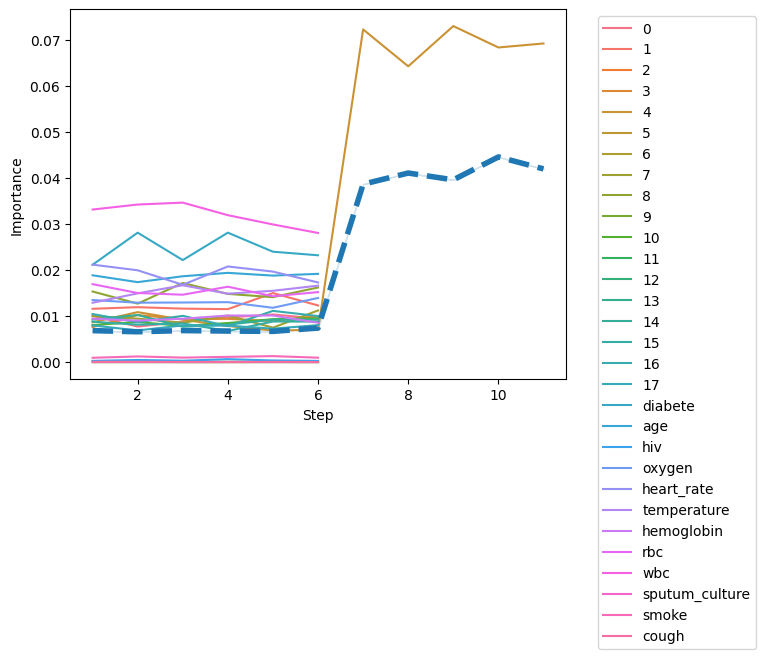

           Feature  Importance
26             wbc    0.039316
18         diabete    0.028697
19             age    0.028047
22      heart_rate    0.024320
23     temperature    0.022086
8                8    0.021854
25             rbc    0.019012
0                0    0.016762
1                1    0.016637
16              16    0.016482
3                3    0.015415
21          oxygen    0.014814
24      hemoglobin    0.014808
10              10    0.014597
4                4    0.014193
7                7    0.013940
15              15    0.013627
17              17    0.013233
14              14    0.012689
28           smoke    0.002773
20             hiv    0.000498
29           cough    0.000083
13              13    0.000000
12              12    0.000000
11              11    0.000000
9                9    0.000000
6                6    0.000000
5                5    0.000000
2                2    0.000000
27  sputum_culture    0.000000
{'wbc': [0.039315872165731465], 'diabet

In [ ]:
disease = pneu # Change it to the disease of your choice in [bron, pneu, tub, art, frac, can, sco, inf]

boruta = eBoruta(n_iter = 20, verbose=2, classification = True, test_stratify = False, pvalue = 0.1, percentile = 70)
boruta.fit(d2, disease);
features = boruta.features_
print(features.accepted, features.rejected, features.tentative)

data = features.history
plot_imp_history(data)
r=boruta.rank(sort = True)
print(r)

dictionary = dict(zip(r['Feature'], r['Importance'].apply(lambda x: [x])))
print(dictionary)